In [19]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
rng = np.random.default_rng()

In [20]:
# Note -- place your own MNIST files in the appropriate directory
train_data = np.loadtxt("./data/mnist/mnist_train.csv", delimiter=',')
test_data = np.loadtxt("./data/mnist/mnist_test.csv", delimiter=',')

In [21]:
train_imgs = train_data[:, 1:]  # (60000, 784)
test_imgs = test_data[:, 1:]  # (10000, 784)
train_labels = train_data[:, 0]  # (60000, )
test_labels = test_data[:, 0]  # (10000, )

In [22]:
# Change the top k input values to 1, rest of the values to 0
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

In [24]:
from scipy.signal import convolve
# k-cap on convolved input pixels
n_examples = 5000
examples = np.zeros((10, n_examples, 784))
for i in range(10):
    examples[i] = k_cap(convolve(train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), cap_size)

In [83]:
n_in = 784
n_neurons = 2000
n_out = n_neurons
cap_size = 200
sparsity = 0.1
n_rounds = 5
beta = 1e0

num_learn_area = 2


# Random mask on input-learning area connections
mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

# Random mask on intra-area recurrent connections
# Choose 10% of connections and not the diagnal
mask_w = (rng.random((num_learn_area, n_neurons, n_neurons)) < sparsity) \
    & np.repeat(np.logical_not(np.eye(n_neurons, dtype=bool))[np.newaxis, ...], num_learn_area, axis=0)
W = np.ones((num_learn_area, n_neurons, n_neurons)) * mask_w
W /= W.sum(axis=1, keepdims=True)

# Random mask on inter-area forward connections
# Choose 10% of connections
mask_fw = (rng.random((num_learn_area, n_neurons, n_neurons)) < sparsity)
C_fw = np.ones((num_learn_area, n_neurons, n_neurons)) * mask_fw
C_fw /= C_fw.sum(axis=1, keepdims=True)

# Random mask on intra-area feedback connections
# Choose 10% of connections
mask_fb = (rng.random((num_learn_area, n_neurons, n_neurons)) < sparsity)
C_fb = np.ones((num_learn_area, n_neurons, n_neurons)) * mask_fb
C_fb /= C_fb.sum(axis=1, keepdims=True)

In [84]:
bias = np.zeros((num_learn_area, n_neurons))
b = -1

activations = np.zeros((10, n_rounds, num_learn_area+1, n_neurons))

# Iterate over each class
for i in range(10):
    
    act_h = np.zeros((num_learn_area+1, n_neurons))
    
    # Iterate over several examples
    for j in range(n_rounds):
        
        input = examples[i, j]
        act_h_new = np.zeros((num_learn_area+1, n_neurons))
        
        # Apply supervision: set assembly in the output area corresponding to class i to 1
        act_h_new[-1, i*cap_size:i*cap_size+cap_size] = 1 
        
        
        # calculate activations
        act_h_new[0] = k_cap(input@A + act_h[0]@W[0] + act_h[1]@C_fb[0] + bias[0], cap_size)
        for t in range(1, num_learn_area):
            act_h_new[t] = k_cap(act_h[t-1]@C_fw[t-1] + act_h[t]@W[t] + act_h[t+1]@C_fb[t] + bias[t], cap_size)
             
                
        # update weights
        A[(input > 0)[:, np.newaxis] & (act_h_new[0] > 0)[np.newaxis, :]] *= 1 + beta 
        for t in range(0, num_learn_area):
            W[t][(act_h[t] > 0)[:, np.newaxis] & (act_h_new[t] > 0)[np.newaxis, :]] *= 1 + beta
            C_fw[t][((act_h[t] > 0)[:, np.newaxis] & (act_h_new[t+1] > 0)[np.newaxis, :]) & (mask_fw[t] > 0)] *= 1 + beta
            C_fb[t][((act_h[t+1] > 0)[:, np.newaxis] & (act_h_new[t] > 0)[np.newaxis, :]) & (mask_fb[t] > 0)] *= 1 + beta
        
        
        activations[i, j] = act_h_new.copy()
        act_h = act_h_new
        
    bias[act_h[:-1] > 0] += b
    A /= A.sum(axis=0, keepdims=True)
    W /= W.sum(axis=1, keepdims=True)
    C_fw /= C_fw.sum(axis=1, keepdims=True)
    C_fb /= C_fb.sum(axis=1, keepdims=True)

<IPython.core.display.Javascript object>


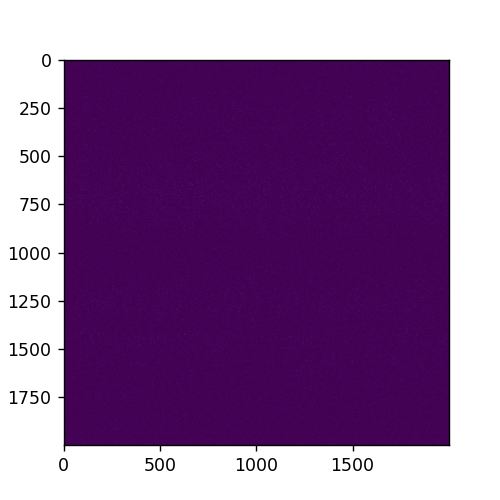

In [146]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.imshow(C_fb[0])   # almost no feedback information from learning area 2 to 1 - fix?

In [93]:
act_test = np.zeros((10, n_rounds+1, num_learn_area+1, n_examples, n_neurons))

for i in np.arange(10):
    
    # Run each example through the model n_round times
    for j in range(n_rounds):
        
        act_test[i, j+1, 0] = k_cap(examples[i]@A + act_test[i, j, 0]@W[0] + act_test[i, j, 1]@C_fb[0], cap_size)
        
        for t in range(1, num_learn_area):
            act_test[i, j+1, t] = k_cap(act_test[i, j, t-1]@C_fw[t-1] + act_test[i, j, t]@W[t] + act_test[i, j, t+1]@C_fb[t], cap_size)
        
        act_test[i, j+1, -1] = k_cap(act_test[i, j+1, -2]@C_fw[-1], cap_size)
        

In [94]:
# output area
outputs = act_test[:, :, -1, ...]
outputs.shape

(10, 6, 5000, 2000)

In [95]:
# first learning area
act_l = act_test[:, :, 0, ...]
act_l.shape

(10, 6, 5000, 2000)

In [96]:
idx = np.arange(n_out)
idx

array([   0,    1,    2, ..., 1997, 1998, 1999])

In [97]:
idx_l = np.full(n_neurons, -1, dtype=int)
act = activations[:, -1, 0, :].copy()  
for i in range(10):
    idx_l[i*cap_size:(i+1)*cap_size] = act[i].argsort()[-cap_size:][::-1]
    act[:, idx_l[i*cap_size:(i+1)*cap_size]] = -1

<IPython.core.display.Javascript object>


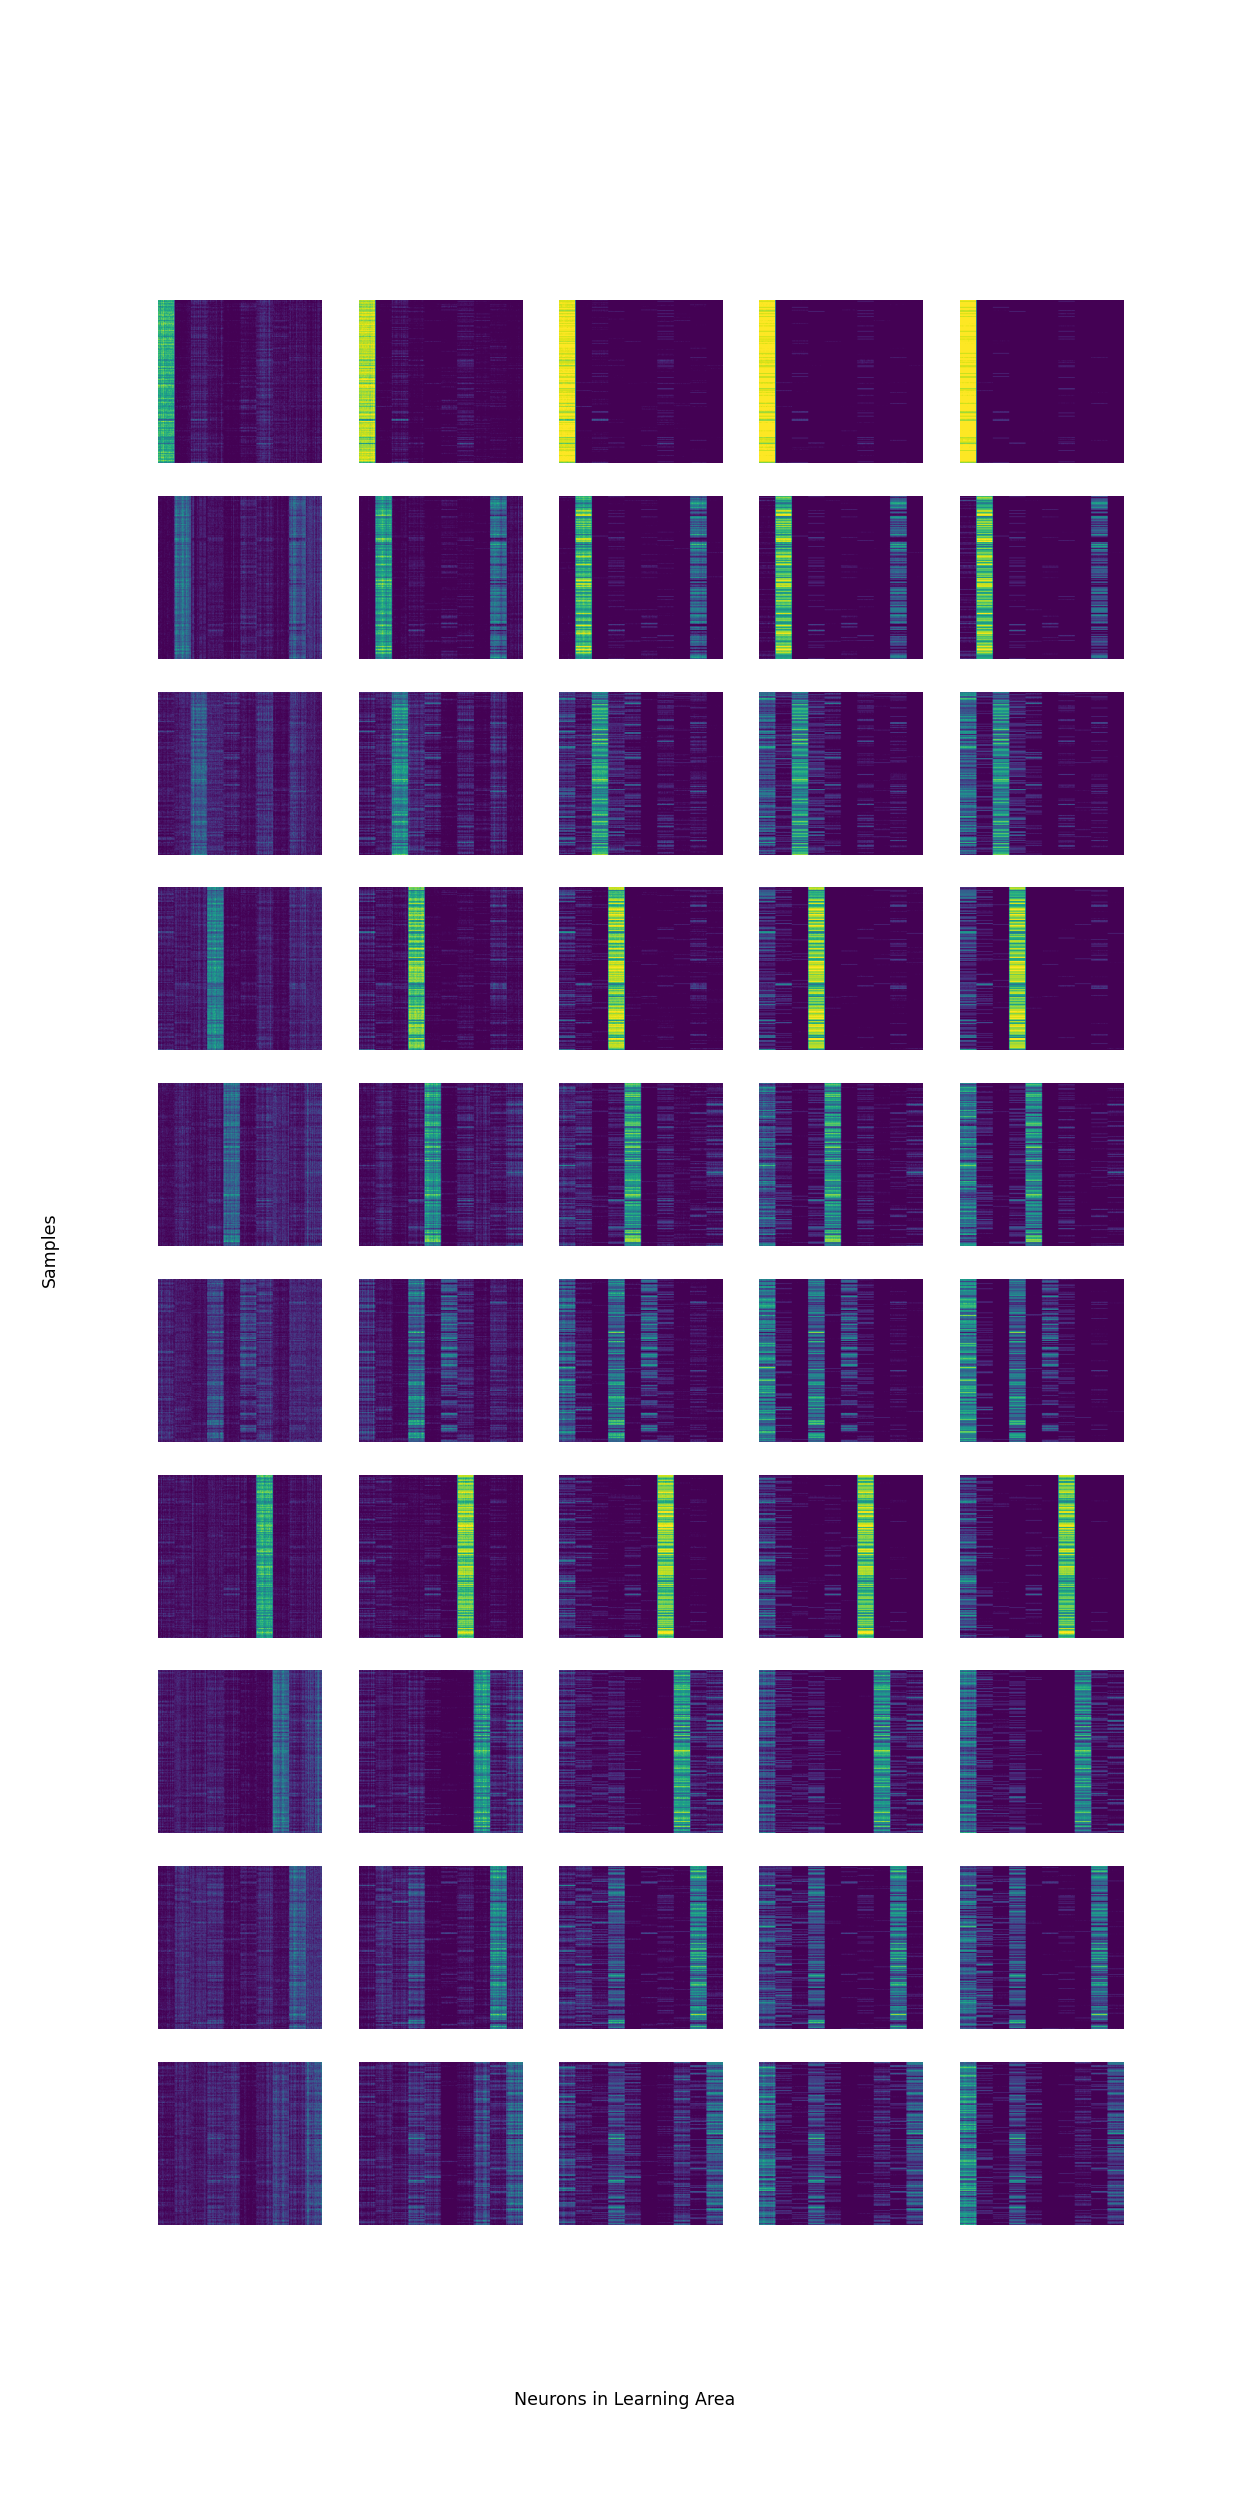

Text(0.04, 0.5, 'Samples')

In [98]:
fig, axes = plt.subplots(10, n_rounds, figsize=(10, 2 * 10), sharex=True, sharey=True)
for ax, output in zip(axes, act_l):
    for i in range(n_rounds):
        ax[i].imshow((output[i+1] > 0)[:n_neurons, idx_l])
        ax[i].set_axis_off()
fig.text(0.5, 0.04, 'Neurons in Learning Area', ha='center', va='center')
fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')

<IPython.core.display.Javascript object>


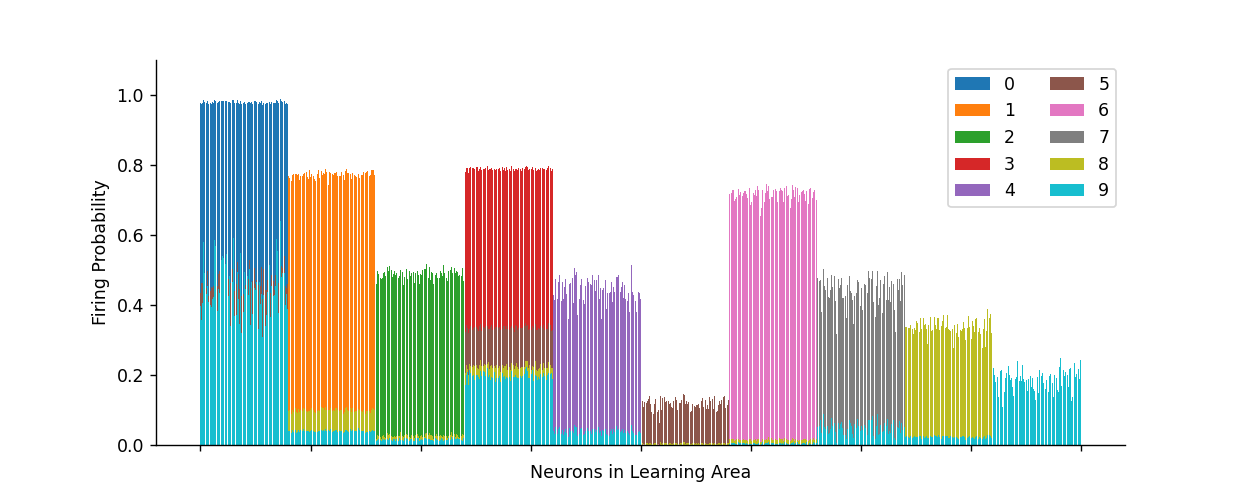

Text(0, 0.5, 'Firing Probability')

In [99]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(10):
    # Pass each sample to the model and get its result
    ax.bar(np.arange(n_neurons), act_l[i, -1].mean(axis=0)[idx_l], label=i)
ax.legend(loc='upper right', ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 1.1])
ax.set_xticklabels([])
ax.set_xlabel('Neurons in Learning Area')
ax.set_ylabel('Firing Probability')

<IPython.core.display.Javascript object>


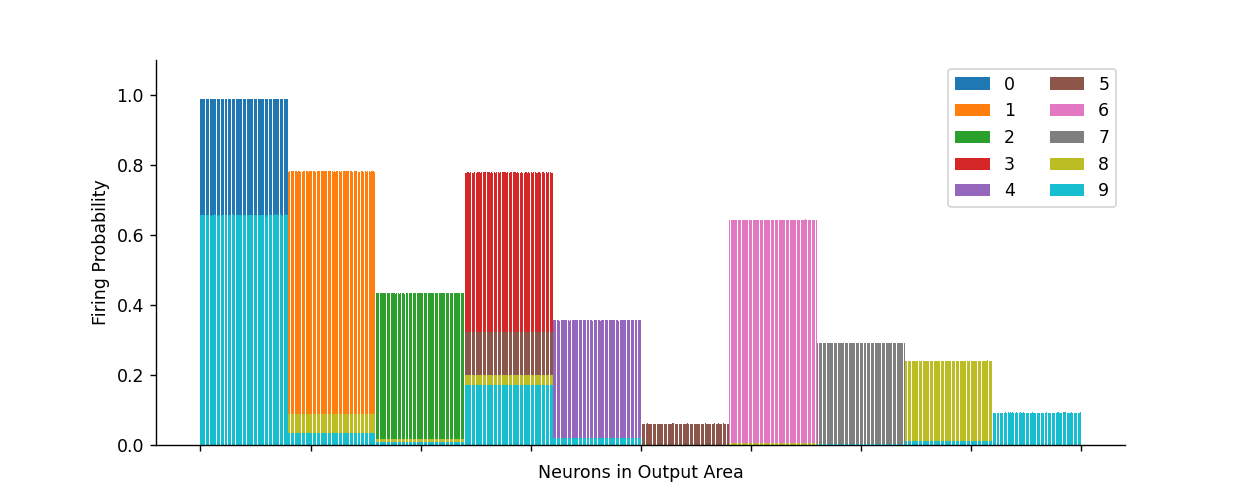

Text(0, 0.5, 'Firing Probability')

In [100]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(10):
    # Pass each sample to the model and get its result 
    ax.bar(np.arange(n_neurons), outputs[i, -1].mean(axis=0)[idx], label=i)
ax.legend(loc='upper right', ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 1.1])
ax.set_xticklabels([])
ax.set_xlabel('Neurons in Output Area')
ax.set_ylabel('Firing Probability')

In [101]:
# We know the assembly of the output area by construction
c = np.zeros((10, n_neurons))
for i in range(10):
    c[i, i*cap_size: i*cap_size+cap_size] = 1

In [138]:
predictions = (outputs[:, 1] @ c.T).argmax(axis=-1)
acc = (predictions == np.arange(10)[:, np.newaxis]).sum(axis=-1) / n_examples

In [139]:
acc, acc.mean()

(array([0.9894, 0.7844, 0.4304, 0.7756, 0.3542, 0.0598, 0.6412, 0.2878,
        0.2372, 0.0898]),
 0.46498)

<IPython.core.display.Javascript object>


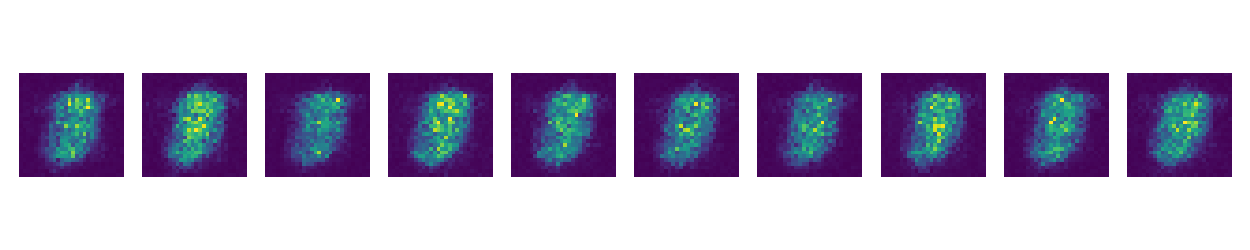

In [45]:
# Ignore this for now because now we cannot map c back to sensory area
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    axes[i].imshow((A * c[i][np.newaxis, :]).sum(axis=1).reshape(28, 28))
    axes[i].set_axis_off()
fig.tight_layout()